In [1]:
# install pygame
# pip install pygame

# install ple
# git clone https://github.com/ntasfi/PyGame-Learning-Environment.git
# cd PyGame-Learning-Environment/
# pip install -e .

# install gym_ple
# pip install gym_ple

In [1]:
%matplotlib inline
import time
import os
 
import gym
from gym.wrappers import Monitor
import gym_ple
import matplotlib
from matplotlib.pyplot import imshow, show
from collections import deque, namedtuple
import numpy as np
import random
from skimage import color, transform

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import warnings
warnings.filterwarnings('ignore')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# env = gym.make('FlappyBird-v0').unwrapped


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


In [2]:
class Environment(object):
    def __init__(self, game='FlappyBird-v0', record=False, width=84, height=84, seed=0):
        self.game = gym.make(game)
        self.game.seed(seed)

        if record:
            self.game = Monitor(self.game, './video', force=True)

        self.width = width
        self.height = height

    def play_sample(self, mode: str = 'human'):
        observation = self.game.reset()

        while True:
            screen = self.game.render(mode=mode)
            if mode == 'rgb_array':
                screen = self.preprocess(screen)
            action = self.game.action_space.sample()
            observation, reward, done, info = self.game.step(action)
            if done:
                break
        self.game.close()

    def preprocess(self, screen):
#         preprocessed = screen[:400, 40:]
        preprocessed = screen
        preprocessed = transform.resize(preprocessed, (self.height, self.width))
        preprocessed = color.rgb2gray(preprocessed)
        preprocessed = preprocessed.astype('float32') / 255.

        return preprocessed

    def init(self):
        return self.game.reset()

    def get_screen(self):
        screen = self.game.render('rgb_array')
        screen = self.preprocess(screen)
        return screen

    def step(self, action: int):
        observation, reward, done, info = self.game.step(action)
        return observation, reward, done, info

    def reset(self):
        observation = self.game.reset()
        observation = self.preprocess(observation)
        return observation
    
    def close(self):
        self.game.close()

    @property
    def action_space(self):
        return self.game.action_space.n
    
    @property
    def observation_space(self):
        return self.game.observation_space

In [3]:
env = Environment()
env.action_space, env.observation_space

WARN: Environment '<class 'gym_ple.ple_env.PLEEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.


(2, Box(512, 288, 3))

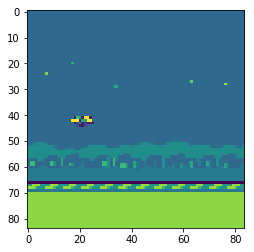

In [4]:
env.init()
env.step(1)
imshow(env.get_screen())

In [5]:
class Memory(object):
    def __init__(self, size, batch_size):
        self.buffer = deque(maxlen=size)
        self.batch_size = batch_size
        self.available = False
        self.Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))
        
    def add(self, state: np.array, action: torch.LongTensor, reward: np.array, next_state: np.array, done):
        state = torch.FloatTensor(state)
        reward = torch.FloatTensor([reward])
        if next_state is not None:
            next_state = torch.FloatTensor(next_state)
        transition = self.Transition(state=state, action=action, reward=reward, next_state=next_state, done=done)
        self.buffer.append(transition)
        
    def sample(self):
        transitions = random.sample(self.buffer, self.batch_size)
        return self.Transition(*(zip(*transitions)))

    def is_ready(self):
        if self.available:
            return True
        else:
            self.available = (len(self.buffer) > self.batch_size)
            return self.available

In [6]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x.view(x.size(0), -1))
        return self.fc2(x)

In [7]:
# x = torch.zeros([1,4,84,84], device=device)
# dqn = DQN().to(device)
# pred = dqn.forward(x)
# pred

In [8]:
class Agent(object):
    def __init__(self):
        self.env = Environment()
        self.dqn = DQN().to(device)
        self.target = DQN().to(device)
        self.target.load_state_dict(self.dqn.state_dict())
        self.target.eval()
        self.target_update_interval = 1000
#         self.optimizer = optim.RMSprop(self.dqn.parameters())
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=0.0001)
        
        #play params
        self.play_interval = 1000
        self.play_repeat = 1
        self.best_steps_done = 0
        self.best_score = -1000
        
        self.seed = 111
        self.gamma = 0.99
        self.epsilon_start = 1.0
        self.epsilon_decay = 100000
        self.epsilon_stop = 0.01
        self.batch_size = 32
        self.max_step = 1000
        self.global_steps = 0
        
        self.memory = Memory(50000, batch_size=self.batch_size)

        self.frame_skipping = 4
        self.state_buffer_size = 4
        self.state_buffer = deque(maxlen=self.state_buffer_size)
        
    def save_checkpoint(self, filename='checkpoints/checkpoint.pth'):
        dirpath = os.path.dirname(filename)

        if not os.path.exists(dirpath):
            os.mkdir(dirpath)

        checkpoint = {
            'dqn': self.dqn.state_dict(),
            'target': self.target.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'global_steps': self.global_steps,
            'best_score': self.best_score,
            'best_steps_done': self.best_steps_done
        }
        torch.save(checkpoint, filename)
        
    def load_checkpoint(self, filename='checkpoints/checkpoint.pth'):
        checkpoint = torch.load(filename)
        self.dqn.load_state_dict(checkpoint['dqn'])
        self.target.load_state_dict(checkpoint['target'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.global_steps = checkpoint['global_steps']
        self.best_score = checkpoint['best_score']
        self.best_steps_done = checkpoint['best_steps_done']
        
        
    def play(self, human=True):
        self.env.reset()
        state = self.get_initial_state()
        steps_done = 0
        total_score = 0

#         self.env.game.seed(self.seed)
        
        while True:

            state = torch.FloatTensor([state]).to(device)
            
            self.dqn.eval()
            action = self.dqn(state).cpu().max(1)[1]

            for _ in range(self.frame_skipping):
                if human:
                    screen = self.env.game.render(mode='human')
                _, reward, done, _ = self.env.step(action)

                next_state = self.env.get_screen()
                self.state_buffer.append(next_state)
                state = np.array(self.state_buffer)

                total_score += reward

                if done:
                    break

            steps_done += 1
            
            if done:
                self.dqn.train()
                break
        self.env.game.close()
        return total_score, steps_done

    def get_initial_state(self):
        self.env.reset()
        state = self.env.get_screen()
        
        self.state_buffer = deque(maxlen=self.state_buffer_size)
        [self.state_buffer.append(state) for _ in range(self.state_buffer_size)]
        return np.array(self.state_buffer)
    
    def optimize(self):
        transitions = self.memory.sample()

        states = torch.cat(transitions.state).to(device)
        actions = torch.cat(transitions.action).to(device)
        rewards = torch.cat(transitions.reward).to(device)
        dones = transitions.done
        
        non_final_mask = torch.tensor(list(map(lambda s: s is not None, transitions.next_state)), 
                                      device=device, dtype=torch.uint8)
        non_final_next_states = torch.cat([s for s in transitions.next_state
                                            if s is not None])
        
        states = states.view([self.batch_size, self.state_buffer_size, self.env.width, self.env.height])
        q_values = self.dqn(states).gather(1, actions)
        
        target_values = torch.zeros(self.batch_size, device=device)
        non_final_next_states = non_final_next_states.view([-1, self.state_buffer_size, self.env.width, self.env.height]).to(device)
        target_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
        
        rewards.data.clamp_(-1, 1)
        
        expected_state_action_values = (target_values * self.gamma) + rewards
        
        loss = F.smooth_l1_loss(q_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.dqn.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        
        reward_score = int(torch.sum(rewards).cpu().detach().numpy())
        
        return loss.cpu().detach().numpy(), reward_score


    def action(self, state):
        eps = self.epsilon_stop + (self.epsilon_start - self.epsilon_stop) * np.exp(-self.global_steps/self.epsilon_decay)
        if np.random.uniform() <= eps:
            state = torch.FloatTensor([state]).to(device)
            with torch.no_grad():
                return self.dqn(state).max(1)[1].view(-1,1).cpu(), eps
        else:
            sample_action = self.env.game.action_space.sample()
            action = torch.LongTensor([[sample_action]])
            return action, eps
        
    def train(self):
        
        while True:
            self.env.reset()
            state = self.get_initial_state()
            
            losses = []
            
            total_rewards = 0
            steps_done = 0
            eps = self.epsilon_start
            
            done = False
            while not done:
                action, e = self.action(state)
                eps = e
                
                for _ in range(self.frame_skipping):
                    _, reward, done, _ = self.env.step(action.item())
                    next_state = self.env.get_screen()
                    self.state_buffer.append(next_state)
                    
                    if done:
                        break
            
            
                next_state = np.array(self.state_buffer)
                
                if done:
                    self.memory.add(state, action, reward, None, done)
                else:
                    self.memory.add(state, action, reward, next_state, done)

                state = next_state
                
                if self.memory.is_ready():
                    l, r = self.optimize()
                    losses.append(l)
                    total_rewards += r

                steps_done += 1
                self.global_steps += 1
                
                # update target network
                if self.global_steps % self.target_update_interval == 0:
                    print('update target network!')
                    self.target.load_state_dict(self.dqn.state_dict())
              
                # Play
                if self.global_steps % self.play_interval == 0:
                    scores = []
                    total_steps_done = []
                    for _ in range(self.play_repeat):
                        score, steps_done = self.play(human=True)
                        scores.append(score)
                        total_steps_done.append(steps_done)
                        
                    real_score = int(np.mean(scores))
                    real_steps_done = int(np.mean(total_steps_done))

                    if self.best_steps_done <= real_steps_done:
                        self.best_score = real_score
                        self.best_steps_done = real_steps_done

                        self.save_checkpoint(
                            filename=f'dqn_checkpoints/chkpoint_{self.best_steps_done}_{self.best_score}.pth')

                    
            print('global steps:{}, steps:{}, loss:{}, rewards:{}, eps:{}'.format(self.global_steps, steps_done, np.mean(losses), total_rewards, eps))
                    
                
                

In [11]:
agent_dqn = Agent() 
agent_dqn.train()

In [10]:

# agent_dqn.save_checkpoint('dqn_checkpoints/exp_01.pth')

In [ ]:
# to improve the training speed
# consider the dynamic batch size, increment with the step

In [14]:
agent_dqn.load_checkpoint('dqn_checkpoints/latest.pth')

In [28]:
# agent_dqn.train()

ERROR! Session/line number was not unique in database. History logging moved to new session 106


In [150]:
t = torch.ones((3,3))
tt = deque([t,t,t])

In [179]:
t.unsqueeze(0).size()

torch.Size([1, 3, 3])

In [152]:
torch.cat(list(tt))

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [66]:
import random
torch.tensor([[np.random.randint(2)]], device=device, dtype=torch.long)

tensor([[0]], device='cuda:0')

In [137]:

torch.zeros_like(t)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [10]:
state = env.reset()

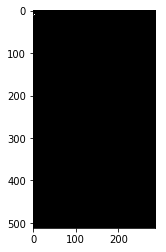

In [13]:
plt.imshow(state)

In [18]:
state = env.render(mode='rgb_array')

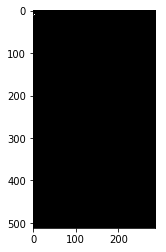

In [19]:
plt.imshow(state)

In [22]:
next_state = env.step(1)

In [ ]:
# next_state

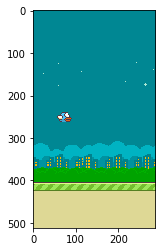

In [25]:
plt.imshow(next_state[0])

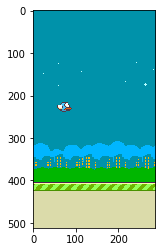

KeyboardInterrupt: 

In [14]:
env.seed(0)
agent = RandomAgent(env.action_space)

episode_count = 100
reward = 0
done = False

for i in range(episode_count):
    ob = env.reset()

    while True:
        action = agent.act(ob, reward, done)

        ob, reward, done, _ = env.step(action)
        
        clear_output(wait=True)
        plt.imshow(ob)
        show()
        time.sleep(.1)
        
        if done:
            break
        # Note there's no env.render() here. But the environment still can open window and
        # render if asked by env.monitor: it calls env.render('rgb_array') to record video.
        # Video is not recorded every episode, see capped_cubic_video_schedule for details.


In [ ]:
# references
# https://github.com/AndersonJo/dqn-pytorch/blob/master/dqn.py